In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import matplotlib as mpl


# LaTeX: Times-like math (newtxmath) + Computer Modern text
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['CMU Serif', 'Computer Modern Roman', 'DejaVu Serif', 'Times New Roman', 'Times']
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{newtxmath}'
# Legend appearance: slightly opaque background
mpl.rcParams['legend.framealpha'] = .8
# PGF export configuration (pdflatex + newtxmath)
mpl.rcParams['pgf.texsystem'] = 'pdflatex'
mpl.rcParams['pgf.preamble'] = r'\usepackage{newtxmath}'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

width_pt = 390
inches_per_pt = 1.0/72.27
golden_ratio = (5**.5 - 1) / 2  # aesthetic figure height

fig_width = width_pt * inches_per_pt  # width in inches
fig_height = fig_width * golden_ratio # height in inches

def compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death):
    """
    Compute the positive nontrivial equilibrium (W_eq, Y_eq) by solving:
      Q1 = W_death / W_birth,   Q2 = Y_death / Y_birth
      W_eq = ½ [ (1 − Q1 + Q2) + sqrt((1 − Q1 + Q2)^2 − 4·Q2 ) ]
      Y_eq = ½ [ (1 − Q2 + Q1) + sqrt((1 − Q2 + Q1)^2 − 4·Q1 ) ]
    Returns (W_eq, Y_eq) if both lie in (0,1); otherwise (None, None).
    """
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth

    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W < 0:
        return None, None
    sqrt_disc_W = np.sqrt(disc_W)
    W_equil = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
    if not (0.0 < W_equil < 1.0):
        return None, None

    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y < 0:
        return None, None
    sqrt_disc_Y = np.sqrt(disc_Y)
    Y_equil = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
    if not (0.0 < Y_equil < 1.0):
        return None, None

    return W_equil, Y_equil

def simulate_segment(V0, W0, Y0, X0, Z0,
                     W_birth, Y_birth, W_death, Y_death,
                     X_in, Z_in, X_out, Z_out,
                     duration, dt,
                     use_X, use_Z,
                     tol=1e-6,
                     stop_at_eq=True):
    """
    Integrate from t=0 to t=duration with initial conditions
      V(0)=V0, W(0)=W0, Y(0)=Y0, X(0)=X0, Z(0)=Z0.
    If stop_at_eq=True, stops early when all |dV|,|dW|,|dY| (and |dX| if use_X, |dZ| if use_Z)
    fall below tol. Otherwise, always runs full duration.
    Returns:
      t_array,
      V_array, W_array, Y_array,
      X_raw_array (unscaled), Z_raw_array (unscaled),
      X_plot = X_raw_array * X_scaler, Z_plot = Z_raw_array * Z_scaler.
    """
    X_scaler = X_out / X_in if (use_X and X_in > 0) else 1.0
    Z_scaler = Z_out / Z_in if (use_Z and Z_in > 0) else 1.0

    N = int(np.ceil(duration / dt)) + 1
    t = np.linspace(0.0, duration, N)

    V = np.zeros(N)
    W = np.zeros(N)
    Y = np.zeros(N)
    X_raw = np.zeros(N)
    Z_raw = np.zeros(N)

    V[0] = V0
    W[0] = W0
    Y[0] = Y0
    X_raw[0] = X0
    Z_raw[0] = Z0

    final_index = N - 1
    for i in range(1, N):
        Vi = V[i-1]
        Wi = W[i-1]
        Yi = Y[i-1]
        Xi = X_raw[i-1]
        Zi = Z_raw[i-1]

        # dV/dt, dW/dt
        dV = W_birth * (1 - Wi - Vi) * Vi * Yi - W_death * Vi
        dW = W_birth * (1 - Wi - Vi) * Wi * Yi - W_death * Wi

        # dY/dt
        dY = Y_birth * (1 - Yi) * Yi * (Vi + Wi) - Y_death * Yi

        # X-coupling
        if use_X:
            dW += X_out * Xi - X_in * Wi
        # Z-coupling
        if use_Z:
            dY += Z_out * Zi - Z_in * Yi

        # dX/dt, dZ/dt
        dX = - X_out * Xi + X_in * Wi
        dZ = - Z_out * Zi + Z_in * Yi

        # If stop_at_eq=True, check for equilibrium
        if stop_at_eq:
            cond = (abs(dV) < tol and abs(dW) < tol and abs(dY) < tol)
            if use_X:
                cond &= abs(dX) < tol
            if use_Z:
                cond &= abs(dZ) < tol
            if cond:
                final_index = i - 1
                break

        # Euler update
        V[i] = Vi + dt * dV
        W[i] = Wi + dt * dW
        Y[i] = Yi + dt * dY
        X_raw[i] = Xi + dt * dX
        Z_raw[i] = Zi + dt * dZ

        # Enforce nonnegativity
        V[i] = max(V[i], 0.0)
        W[i] = max(W[i], 0.0)
        Y[i] = max(Y[i], 0.0)
        X_raw[i] = max(X_raw[i], 0.0)
        Z_raw[i] = max(Z_raw[i], 0.0)

    # Truncate arrays
    t_trunc     = t[: final_index + 1]
    V_trunc     = V[: final_index + 1]
    W_trunc     = W[: final_index + 1]
    Y_trunc     = Y[: final_index + 1]
    X_raw_trunc = X_raw[: final_index + 1]
    Z_raw_trunc = Z_raw[: final_index + 1]

    X_plot = X_raw_trunc * X_scaler
    Z_plot = Z_raw_trunc * Z_scaler

    return t_trunc, V_trunc, W_trunc, Y_trunc, X_raw_trunc, Z_raw_trunc, X_plot, Z_plot

def compute_deltaW_curve(W_birth, Y_birth, W_death, Y_death,
                         X_in, Z_in, X_out, Z_out,
                         Time, dt, use_X, use_Z,
                         num_points, severity,
                         perturb_V, perturb_W, perturb_Y,
                         tol):
    """
    Compute W0_values and corresponding ΔW for a given 'severity'. 
    Here 'severity' is interpreted so that the perturbation multiplier = (1 - severity). 
    ΔW = W_final - W0 with that multiplier at t=0, simulated to Time with early‐stop. 
    Returns:
      - W0_surv:     array of initial W0 values that survive (W_final ≥ tol),
      - DeltaW_surv: ΔW = W_final - W0,
      - integral_surv: ∫|ΔW| dW0 over surviving range,
      - W0_min_surv: the smallest W0 that survives (float or None).
    """
    W_eq, Y_eq = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
    if (W_eq is None) or (Y_eq is None):
        raise RuntimeError("No positive, nontrivial equilibrium exists.")

    W0_values = np.linspace(0.0, W_eq, num_points)
    DeltaW = np.zeros_like(W0_values)
    W_final_vals = np.zeros_like(W0_values)

    for idx, W0 in enumerate(W0_values):
        V0 = W_eq - W0
        X0 = (X_in / X_out) * W0 if use_X else 0.0
        Z0 = (Z_in / Z_out) * Y_eq if use_Z else 0.0

        # Apply perturbation multiplier = (1 - severity)
        # If perturb_W is requested, affect both V and W (total W-species)
        V0p = ((1 - severity) * V0) if (perturb_V or perturb_W) else V0
        W0p = ((1 - severity) * W0) if perturb_W else W0
        Y0p = ((1 - severity) * Y_eq) if perturb_Y else Y_eq

        _, _, W_full, _, _, _, _, _ = simulate_segment(
            V0=V0p, W0=W0p, Y0=Y0p, X0=X0, Z0=Z0,
            W_birth=W_birth, Y_birth=Y_birth,
            W_death=W_death, Y_death=Y_death,
            X_in=X_in, Z_in=Z_in,
            X_out=X_out, Z_out=Z_out,
            duration=Time, dt=dt,
            use_X=use_X, use_Z=use_Z,
            tol=tol,
            stop_at_eq=True
        )
        W_final = W_full[-1]
        W_final_vals[idx] = W_final
        DeltaW[idx] = W_final - W0

    # survival = W_final ≥ tol
    survival_mask = (W_final_vals >= tol)
    if not np.any(survival_mask):
        return np.array([]), np.array([]), 0.0, None

    first_surv_idx = np.argmax(survival_mask)
    W0_surv = W0_values[first_surv_idx:]
    DeltaW_surv = DeltaW[first_surv_idx:]
    integral_surv = np.trapz(np.abs(DeltaW_surv), W0_surv)
    W0_min_surv = W0_values[first_surv_idx]

    return W0_surv, DeltaW_surv, integral_surv, W0_min_surv

def compare_severities(W_birth, Y_birth, W_death, Y_death,
                       X_in, Z_in, X_out, Z_out,
                       Time=200.0, dt=0.01,
                       use_X=True, use_Z=True,
                       num_points=100,
                       severity_range=(0.2, 0.4), n_sev=5,
                       perturb_V=False, perturb_W=False, perturb_Y=True,
                       tol=1e-6):
    """
    For severities in linspace between severity_range[0] and severity_range[1], compute ΔW vs W0.
    Each ΔW curve uses perturbation multiplier = (1 - severity).  Plot only surviving range.
    """
    severities = np.linspace(severity_range[0], severity_range[1], n_sev)
    print(severities)
    try:
        base_cmap = cm.colormaps['viridis']
    except AttributeError:
        base_cmap = cm.get_cmap('viridis')
    cmap = base_cmap.reversed()
    norm = mcolors.Normalize(vmin=severity_range[0], vmax=severity_range[1])

    fig, ax = plt.subplots(figsize=(8, 6))
    integrals = np.zeros(n_sev)
    curves = []
    valid_idx = []

    for i, sev in enumerate(severities):
        W0_surv, DeltaW_surv, integral_surv, W0_min_surv = compute_deltaW_curve(
            W_birth=W_birth, Y_birth=Y_birth,
            W_death=W_death, Y_death=Y_death,
            X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
            Time=Time, dt=dt, use_X=use_X, use_Z=use_Z,
            num_points=num_points, severity=sev,
            perturb_V=perturb_V, perturb_W=perturb_W, perturb_Y=perturb_Y,
            tol=tol
        )
        if W0_min_surv is None:
            print(f"Warning: severity={sev:.3f} yields no survivors. Skipping.")
            integrals[i] = 0.0
            curves.append((None, None, None))
            continue
        integrals[i] = integral_surv
        curves.append((W0_surv, DeltaW_surv, W0_min_surv))
        valid_idx.append(i)

    if not valid_idx:
        raise RuntimeError("All severities crash.")

    max_int = np.max(integrals[valid_idx])
    rel_ints = integrals / max_int

    print("Severity   Relative ∫|ΔW| dW₀")
    for sev, rel in zip(severities, rel_ints):
        print(f"{sev:.3f}      {rel:.4f}")

    for i in valid_idx:
        sev = severities[i]
        W0_surv, DeltaW_surv, _ = curves[i]
        color = cmap(norm(sev))
        ax.plot(W0_surv, DeltaW_surv, color=color, linewidth=1.8,
                label=f"sev={sev:.3f}, W₀₋min={curves[i][2]:.4f}")

    ax.axhline(0.0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel(r'$W_{0}$', fontsize=12)
    ax.set_ylabel(r'$\Delta W$', fontsize=12)
    ax.set_title('Severity variation (surviving range)', fontsize=14)
    ax.grid(True)
    ax.legend(loc='upper left', fontsize=8, bbox_to_anchor=(1.2, 1))

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.02, aspect=30)
    cbar.set_label('severity', fontsize=12)

    plt.tight_layout()
    plt.show()

def test_plot(W_birth, Y_birth, W_death, Y_death,
              X_in, Z_in, X_out, Z_out,
              W0,
              Time=200.0, dt=0.01,
              use_X=True, use_Z=True,
              severity=0.5,
              perturb_V=False, perturb_W=False, perturb_Y=True,
              perturb_time=20.0,
              tol=1e-6):
    """
    Build a time‐series plot for a fixed W0 using perturbation multiplier = (1 - severity).
    1) Compute (W_eq, Y_eq).
    2) Verify W0 ∈ [0, W_eq], then set V0 = W_eq - W0, X0, Z0.
    3) Stage A: simulate from t=0 → perturb_time (no stopping).
    4) At t=0 apply perturbation: V_mid=(1−severity)*V_eq_pre, etc.
    5) Stage B: simulate from t=0 → Time (no stopping).
    6) Concatenate and plot V, W, Y, X, Z over t ∈ [−perturb_time, Time].
    Returns results dict.
    """
    # (1) equilibrium
    W_eq, Y_eq = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
    if (W_eq is None) or (Y_eq is None):
        raise RuntimeError("No positive equilibrium exists.")

    if not (0.0 <= W0 <= W_eq):
        raise ValueError(f"W0 must lie in [0, {W_eq:.4f}].")

    X_scaler = X_out / X_in if (use_X and X_in > 0) else 1.0
    Z_scaler = Z_out / Z_in if (use_Z and Z_in > 0) else 1.0

    V0_eq = W_eq - W0
    X0_eq = (X_in / X_out) * W0 if use_X else 0.0
    Z0_eq = (Z_in / Z_out) * Y_eq if use_Z else 0.0

    # Stage A
    t_pre, V_pre, W_pre, Y_pre, X_pre_raw, Z_pre_raw, X_pre_plot, Z_pre_plot = simulate_segment(
        V0=V0_eq, W0=W0, Y0=Y_eq, X0=X0_eq, Z0=Z0_eq,
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in,
        X_out=X_out, Z_out=Z_out,
        duration=perturb_time, dt=dt,
        use_X=use_X, use_Z=use_Z,
        tol=tol,
        stop_at_eq=False
    )
    t_pre_shifted = t_pre - perturb_time

    V_eq_pre = V_pre[-1]
    W_eq_pre = W_pre[-1]
    Y_eq_pre = Y_pre[-1]
    X_eq_pre = X_pre_plot[-1]
    Z_eq_pre = Z_pre_plot[-1] if use_Z else None

    # (4) apply perturbation multiplier = (1 - severity)
    # Perturbation affecting W applies to both V and W components
    V_mid = ((1 - severity) * V_eq_pre) if (perturb_V or perturb_W) else V_eq_pre
    W_mid = ((1 - severity) * W_eq_pre) if perturb_W else W_eq_pre
    Y_mid = ((1 - severity) * Y_eq_pre) if perturb_Y else Y_eq_pre

    # Stage B
    t_post, V_post, W_post, Y_post, X_post_raw, Z_post_raw, X_post_plot, Z_post_plot = simulate_segment(
        V0=V_mid, W0=W_mid, Y0=Y_mid, X0=X0_eq, Z0=Z0_eq,
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in,
        X_out=X_out, Z_out=Z_out,
        duration=Time, dt=dt,
        use_X=use_X, use_Z=use_Z,
        tol=tol,
        stop_at_eq=False
    )

    t_full = np.concatenate((t_pre_shifted, t_post))
    V_full = np.concatenate((V_pre, V_post))
    W_full = np.concatenate((W_pre, W_post))
    Y_full = np.concatenate((Y_pre, Y_post))
    X_full = np.concatenate((X_pre_plot, X_post_plot))
    Z_full = np.concatenate((Z_pre_plot, Z_post_plot)) if use_Z else None

    V_final = V_full[-1]
    W_final = W_full[-1]
    Y_final = Y_full[-1]
    X_final = X_full[-1]
    Z_final = Z_full[-1] if use_Z else None
    delta_W_test = W_final - W_eq_pre

    # Time‐series plot
    plt.figure(figsize=(8, 5))
    if use_X:
        plt.plot(t_full, X_full, label=r'$X(t)$', color='gold', linewidth=1.5)
    if use_Z:
        plt.plot(t_full, Z_full, label=r'$Z(t)$', color='skyblue', linewidth=1.5)
    plt.plot(t_full, Y_full, label=r'$Y(t)$', color='darkblue', linewidth=1.5)
    plt.plot(t_full, V_full, label=r'$V(t)$', color='orange', linewidth=1.5)
    plt.plot(t_full, W_full, label=r'$W(t)$', color='darkgreen', linewidth=1.5)

    plt.axvline(x=0.0, color='gray', linestyle='--', lw=1)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Population', fontsize=12)
    plt.title(
        f'Time Series at $W_{0} = {W0:.4f}$ (severity={severity:.2f})\n'
        + rf'$\Delta W_{{\mathrm{{test}}}} = {delta_W_test:.4f}$',
        fontsize=14
    )
    plt.legend(loc='upper right', fontsize=9)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'W_eq'        : W_eq,
        'Y_eq'        : Y_eq,
        'W0'          : W0,
        'V_eq_pre'    : V_eq_pre,
        'W_eq_pre'    : W_eq_pre,
        'Y_eq_pre'    : Y_eq_pre,
        'X_eq_pre'    : X_eq_pre,
        'Z_eq_pre'    : Z_eq_pre,
        'V_mid'       : V_mid,
        'W_mid'       : W_mid,
        'Y_mid'       : Y_mid,
        't_full'      : t_full,
        'V_full'      : V_full,
        'W_full'      : W_full,
        'Y_full'      : Y_full,
        'X_full'      : X_full,
        'Z_full'      : Z_full,
        'delta_W_test': delta_W_test
    }



In [ ]:
def compute_deltaW_curve(W_birth, Y_birth, W_death, Y_death,
                         X_in, Z_in, X_out, Z_out,
                         Time, dt, use_X, use_Z,
                         num_points, severity,
                         perturb_V, perturb_W, perturb_Y,
                         tol):
    """
    Compute W0_values and corresponding ΔW for a given 'severity',
    then trim off every W0 whose (W_final + V_final) < 0.1·W_eq.

    Returns:
      - W0_surv       : 1D array of surviving W0 (starting at the minimal surviving W0)
      - DeltaW_surv   : corresponding ΔW = W_final − W0
      - integral_surv : ∫|ΔW| dW0 over that surviving range
      - W0_min_surv   : the smallest W0 that survives, or None if none survive
    """
    W_eq, Y_eq = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
    if (W_eq is None) or (Y_eq is None):
        raise RuntimeError("No positive, nontrivial equilibrium exists.")

    W0_values    = np.linspace(0.0, W_eq, num_points)
    DeltaW       = np.zeros_like(W0_values)
    W_final_vals = np.zeros_like(W0_values)
    V_final_vals = np.zeros_like(W0_values)

    for idx, W0 in enumerate(W0_values):
        V0 = W_eq - W0
        X0 = (X_in / X_out) * W0 if use_X else 0.0
        Z0 = (Z_in / Z_out) * Y_eq if use_Z else 0.0

        M   = 1.0 - severity
        # If perturb_W is requested, affect both V and W (total W-species)
        V0p = (M * V0)   if (perturb_V or perturb_W) else V0
        W0p = (M * W0)   if perturb_W else W0
        Y0p = (M * Y_eq) if perturb_Y else Y_eq

        _, V_arr, W_arr, Y_arr, _, _, _, _ = simulate_segment(
            V0=V0p,  W0=W0p,  Y0=Y0p,  X0=X0,  Z0=Z0,
            W_birth=W_birth, Y_birth=Y_birth,
            W_death=W_death, Y_death=Y_death,
            X_in=X_in, Z_in=Z_in,
            X_out=X_out, Z_out=Z_out,
            duration=Time, dt=dt,
            use_X=use_X, use_Z=use_Z,
            tol=tol,
            stop_at_eq=True
        )
        W_final = W_arr[-1]
        V_final = V_arr[-1]

        W_final_vals[idx] = W_final
        V_final_vals[idx] = V_final
        DeltaW[idx]       = W_final - W0

    threshold     = 0.1 * W_eq
    survival_mask = (W_final_vals + V_final_vals >= threshold)
    if not np.any(survival_mask):
        return np.array([]), np.array([]), 0.0, None

    first_surv_idx = np.argmax(survival_mask)
    W0_surv        = W0_values[first_surv_idx:]
    DeltaW_surv    = DeltaW[first_surv_idx:]
    integral_surv  = np.trapz(np.abs(DeltaW_surv), W0_surv)
    W0_min_surv    = W0_values[first_surv_idx]

    return W0_surv, DeltaW_surv, integral_surv, W0_min_surv

def compare_severities(W_birth, Y_birth, W_death, Y_death,
                       X_in, Z_in, X_out, Z_out,
                       Time=200.0, dt=0.01,
                       use_X=True, use_Z=True,
                       num_points=100,
                       severity_range=(0.2, 0.4), n_sev=5,
                       perturb_W=False, perturb_Y=True,
                       tol=1e-6,
                       verbose=False):
    """
    For severities in [severity_range[0], severity_range[1]] (n_sev points),
    compute ΔW vs W0—but only over the surviving subrange, defined by
    (W_final + V_final) ≥ 0.1·W_eq.  Plot each truncated curve in reversed viridis,
    draw a vertical dashed line at each threshold W0_min_surv (if > 0),
    and save a PDF of the figure into a single folder named 'compare_severities'.
    All PDFs go into that folder, with integer‐suffix filenames to avoid overwriting.
    If verbose=False, suppress all print statements.
    """
    severities = np.linspace(severity_range[0], severity_range[1], n_sev)
    print(severities) if verbose else None

    try:
        base_cmap = cm.colormaps['viridis']
    except AttributeError:
        base_cmap = cm.get_cmap('viridis')
    cmap = base_cmap.reversed()
    norm = mcolors.Normalize(vmin=severity_range[0], vmax=severity_range[1])

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    integrals = np.zeros(n_sev)
    curves   = []
    valid_idx = []

    # 1) Compute each ΔW‐curve (truncated) and record its W0_min_surv
    for i, sev in enumerate(severities):
        W0_surv, DeltaW_surv, integral_surv, W0_min_surv = compute_deltaW_curve(
            W_birth=W_birth, Y_birth=Y_birth,
            W_death=W_death, Y_death=Y_death,
            X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
            Time=Time, dt=dt, use_X=use_X, use_Z=use_Z,
            num_points=num_points,
            severity=sev,
            perturb_V=False, perturb_W=perturb_W, perturb_Y=perturb_Y,
            tol=tol
        )

        if W0_min_surv is None:
            if verbose:
                print(f"Warning: severity={sev:.3f} → no survivors. Skipping.")
            curves.append((None, None, None))
            integrals[i] = 0.0
            continue

        curves.append((W0_surv, DeltaW_surv, W0_min_surv))
        integrals[i] = integral_surv
        valid_idx.append(i)

    if len(valid_idx) == 0:
        raise RuntimeError("All severities lead to extinction; no plot generated.")

    max_int = np.max(integrals[valid_idx])
    rel_ints = integrals / max_int

    if verbose:
        print("Severity   Relative ∫|ΔW| dW₀")
        for sev, rel in zip(severities, rel_ints):
            print(f"{sev:.3f}      {rel:.4f}")

    # 2) Plot each truncated ΔW‐curve plus a vertical line at W0_min_surv (if > 0)
    for i in valid_idx:
        sev            = severities[i]
        W0_surv, DeltaW_surv, W0_min_surv = curves[i]
        color          = cmap(norm(sev))

        # 2a) the truncated curve
        ax.plot(
            W0_surv, DeltaW_surv,
            color=color, linewidth=1.8,
            label=f"sev={sev:.3f}, W₀₋min={W0_min_surv:.4f}"
        )

        # 2b) vertical line from y=0 up to ΔW_surv[0], only if W0_min_surv > 0
        if W0_min_surv > 0.0:
            delta_at_threshold = DeltaW_surv[0]
            ax.vlines(
                x=W0_min_surv,
                ymin=0.0,
                ymax=delta_at_threshold,
                color=color,
                linestyle='--',
                linewidth=1,
                alpha=0.7
            )

    if perturb_W:
        perturb = r"$W^a$ and $\widetilde{W}^a$"
    else:
        perturb = r"$Y$"
    ax.axhline(0.0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel(r'$W^a(0)$', fontsize=10)
    ax.set_ylabel(r'$\Delta W^a$', fontsize=10)
    # Valid LaTeX: keep math fragments delimited by $...$ and plain text outside
    ax.set_title(r'$\Delta W^a$ vs $W^a(0)$ after one perturbation' + '\n(' + perturb + r' perturbed, $\widetilde{W}^a(0) = W_{(eq,+)}-W^a(0)$)', fontsize=12)
    ax.grid(True)

    # 3) Colorbar for severity
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.02, aspect=30)
    cbar.set_label('severity', fontsize=10)

    # 4) Legend (uncomment if desired)
    # ax.legend(loc='upper left', fontsize=8, framealpha=0.9, bbox_to_anchor=(1.2, 1))

    plt.tight_layout()

    # --------------------------
    # 5) Saving logic (all PDFs in the same folder)
    folder_name = "compare_severities"
    os.makedirs(folder_name, exist_ok=True)

    base_pdf = "compare_severities"
    pattern = os.path.join(folder_name, base_pdf + "*.pdf")
    existing_pdfs = glob.glob(pattern)
    if not existing_pdfs:
        pdf_name = base_pdf + ".pdf"
    else:
        taken = set()
        for p in existing_pdfs:
            stem = os.path.basename(p)
            tail = stem.replace(base_pdf, "").replace(".pdf", "")
            if tail == "":
                taken.add(0)
            elif tail.isdigit():
                taken.add(int(tail))
        k = 0
        while k in taken:
            k += 1
        pdf_name = f"{base_pdf}{k}.pdf"

    full_path = os.path.join(folder_name, pdf_name)
    plt.savefig(full_path)
    if verbose:
        print(f"Figure saved to: {full_path}")
    # --------------------------

    plt.show()

[0.4        0.42105263 0.44210526 0.46315789 0.48421053 0.50526316
 0.52631579 0.54736842 0.56842105 0.58947368 0.61052632 0.63157895
 0.65263158 0.67368421 0.69473684 0.71578947 0.73684211 0.75789474
 0.77894737 0.8       ]


/var/folders/57/ffrpkhfx7xq73dykhyvrqgw40000gn/T/ipykernel_30578/3990889092.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = cm.get_cmap('viridis')


Severity   Relative ∫|ΔW| dW₀
0.400      0.0872
0.421      0.1006
0.442      0.1155
0.463      0.1323
0.484      0.1510
0.505      0.1720
0.526      0.1955
0.547      0.2218
0.568      0.2513
0.589      0.2844
0.611      0.3217
0.632      0.3637
0.653      0.4111
0.674      0.4649
0.695      0.5261
0.716      0.5959
0.737      0.6760
0.758      0.7682
0.779      0.8752
0.800      1.0000
Figure saved to: compare_severities/compare_severities4.pdf


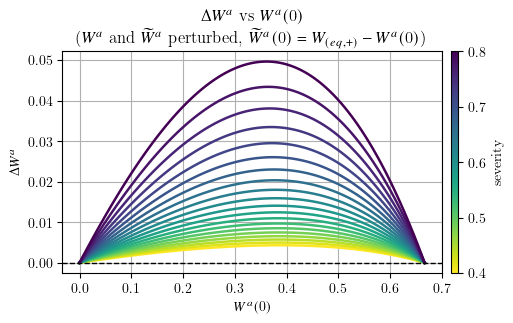

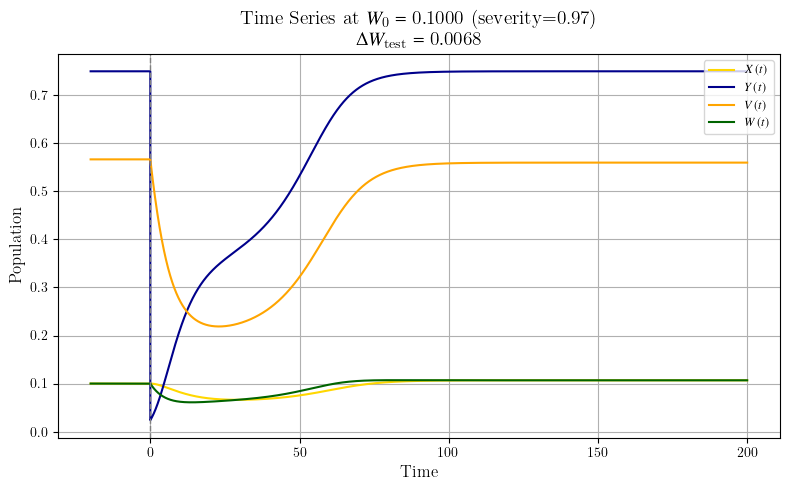

In [42]:
# Example usage:
if __name__ == "__main__":
    W_birth = 0.4
    W_death = 0.1
    Y_birth = 0.9
    Y_death = 0.15

    X_in = 0.1
    X_out = 0.1
    Z_in = 0.5
    Z_out = 0.25

    Time = 400.0
    dt = 0.1

    use_X = True
    use_Z = False

    num_points = 100

    # Compare severities
    compare_severities(
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
        Time=Time, dt=dt, use_X=use_X, use_Z=use_Z,
        num_points=num_points,
        severity_range=(0.4, .8), n_sev=20,
         perturb_W=True, perturb_Y=False,
        tol=1e-6, verbose=True
    )

    # Test‐plot at W0 = 0.1, with severity interpreted as 1−severity
    test_plot(
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
        W0=0.1,
        Time=200.0, dt=0.01,
        use_X=use_X, use_Z=use_Z,
        severity=0.96842105,  # actual shock multiplier = (1 - 0.3) = 0.7
        perturb_V=False, perturb_W=False, perturb_Y=True,
        perturb_time=20.0,
        tol=1e-6
    )